4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/20
600/600 [==============================] - 15s 23ms/step - loss: 304.5818 - val_loss: 282.4040
Epoch 2/20
600/600 [==============================] - 10s 16ms/step - loss: 278.0150 - val_loss: 276.7773
Epoch 3/20
600/600 [==============================] - 7s 12ms/step - loss: 273.8300 - val_loss: 274.0468
Epoch 4/20
600/600 [==============================] - 6s 11ms/step - loss: 271.9576 - val_loss: 272.8419
Epoch 5/20
600/600 [==============================] - 7s 12ms/step - loss: 270.7055 - val_loss: 271.7209
Epoch 6/20
600/600 [==============================] - 7s 11ms/step - loss: 269.7522 - val_loss: 271.9875
Epoch 7/20
600/600 [==============================] - 7s 12ms/step - loss: 268.9249 - val_loss: 269.4949
Epoch 8/20
600/600 [==============================] - 8s 13ms/step - loss: 268.2874 - val_loss: 269.0603
Epoch 9/20
600/600 [==============================] - 11s 18ms/step - loss: 267.7211 - val_loss

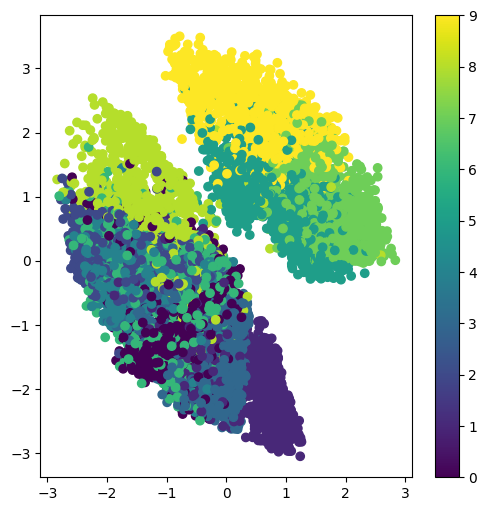

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load and preprocess the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Parameters
original_dim = x_train.shape[1]
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 20

# VAE model
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Custom loss function for VAE
xent_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# Build VAE model
vae = Model(inputs, x_decoded_mean)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

# Train the VAE model
vae.fit(x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

# Encoder model
encoder = Model(inputs, z_mean)

# Display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()


1/1 [==============================] - 0s 30ms/step


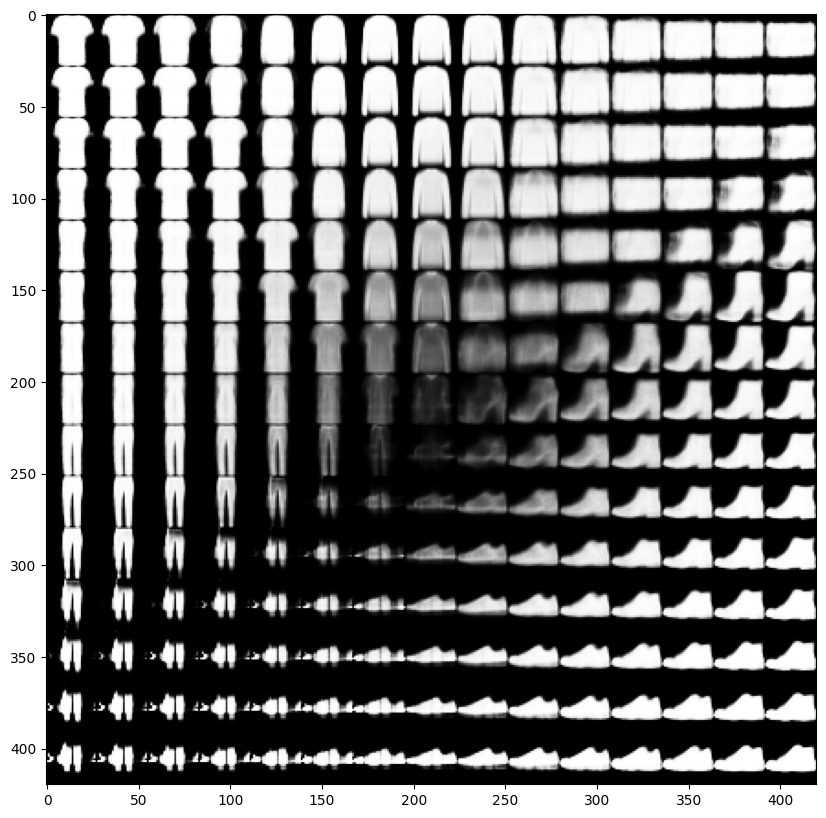

In [ ]:
# Decoder model
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# Generate samples from the latent space
n = 15  # Number of samples
digit_size = 28  # Size of the generated images
figure = np.zeros((digit_size * n, digit_size * n))

# Sample from the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Display the generated images
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
